## Import Dependencies

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, ResNet101, DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, LSTM, Dense, Bidirectional, Conv2D, MaxPooling2D, Flatten, Dropout, Conv1D, MaxPooling1D, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import random
import tqdm
import os

from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
import sklearn.model_selection
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## Connect to Drive (Not used)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Unzip the loaded folder on Colab

In [ ]:
!unzip "/content/mel.zip"

Streaming output truncated to the last 5000 lines.
  inflating: mel/test/metal/metal_metal.00094.wav_0.png  
  inflating: mel/test/metal/metal_metal.00094.wav_1.png  
  inflating: mel/test/metal/metal_metal.00094.wav_2.png  
  inflating: mel/test/metal/metal_metal.00094.wav_3.png  
  inflating: mel/test/metal/metal_metal.00094.wav_4.png  
  inflating: mel/test/metal/metal_metal.00094.wav_5.png  
  inflating: mel/test/metal/metal_metal.00095.wav_0.png  
  inflating: mel/test/metal/metal_metal.00095.wav_1.png  
  inflating: mel/test/metal/metal_metal.00095.wav_2.png  
  inflating: mel/test/metal/metal_metal.00095.wav_3.png  
  inflating: mel/test/metal/metal_metal.00095.wav_4.png  
  inflating: mel/test/metal/metal_metal.00095.wav_5.png  
  inflating: mel/test/metal/metal_metal.00096.wav_0.png  
  inflating: mel/test/metal/metal_metal.00096.wav_1.png  
  inflating: mel/test/metal/metal_metal.00096.wav_2.png  
  inflating: mel/test/metal/metal_metal.00096.wav_3.png  
  inflating: mel/test

## Metrics Calculation function and showing the heatmap of confusion_matrix

In [ ]:
def metrics_calculation(model, features_test, labels_test, genres, rnn_flag= False):
  # For evaluation of model on test data
  # logger.info("evalutaing performance")
  # loss, accuracy = model.evaluate(features_test, labels_test)
  # logger.info(f'Test accuracy : {accuracy}')

  predictions = model.predict(features_test)
  predicted_classes = np.argmax(predictions, axis=1)

  cm = confusion_matrix(labels_test, predicted_classes)
  sns.heatmap(cm, annot=True, xticklabels=genres, yticklabels=genres)

## Loading Train and Test Data (Features) Approach 2

In [ ]:
# założenie jest takie że w katalogu są podkatalogi (nie ma innych plików), a w tych podkatalogach pliki z obrazkami
import cv2  # biblioteka graficzna opencv
import os   # functions for interacting with the operating system
def load_img_approach_2(indir):  # definicja funkcji
  samples = []  # puste listy pythonowe
  labels = []
  trainSamples = []
  trainLabels = []
  testSamples = []
  testLabels = []
  print('os.listdir(indir)= ',os.listdir(indir))    # RB test
  print('indir= ',indir)    # RB test

  for dir in os.listdir(indir):
    for class_dir in os.listdir(indir + '/'+ dir):  # dla każdego podkatalogu z podanego katalogu
        if not os.path.isdir(indir+ '/'+ dir+'/'+class_dir):
          print('os.path.isdir(indir+'/'+class_dir)= ',os.path.isdir(dir+'/'+class_dir))    # RB test
          continue

        print("Loading:",class_dir)  # wypisanie nazwy klasy - czyli nazwy katalogu z którego pobierane są obrazki
        the_class = class_dir

        for file in os.listdir(indir+ '/'+ dir + '/' + class_dir):
            image = cv2.imread("{}/{}/{}/{}".format(indir,dir,class_dir,file))

            samples.append(image)  # dodanie obrazków
            labels.append(the_class)  # dodanie klas
            if(dir == "train"):
              trainSamples.append(image)
              trainLabels.append(the_class)
            else:
              testSamples.append(image)
              testLabels.append(the_class)

  samples = np.array(samples) # zamiana na tablice numpy
  labels = np.array(labels) # zamiana na tablice numpy
  # print('obrazek: ',image)   # RB test
  print('obrazek.shape: ',image.shape)   # RB test
  return samples,labels, np.array(trainSamples), np.array(trainLabels), np.array(testSamples), np.array(testLabels)

# pass as param the folder name that contains the features
samples, labels, trainSamples, trainLabels, testSamples, testLabels = load_img_approach_2('./mel')  # wywołanie funkcji dla zbioru danych
print('loaded',len(samples),' samples')  # wypisanie liczby próbek - obrazków
print('classes',set(labels)) # wypisanie nazw klas
print('loaded train',len(trainSamples),' samples')  # wypisanie liczby próbek - obrazków
print('loaded train',len(trainLabels),' labels')  # wypisanie liczby próbek - obrazków
print('loaded test',len(testLabels),' labels')  # wypisanie liczby próbek - obrazków
print('loaded test',len(testSamples),' samples')

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

os.listdir(indir)=  ['test', 'train']
indir=  ./mel
Loading: metal
Loading: disco
Loading: classical
Loading: rock
Loading: country
Loading: blues
Loading: jazz
Loading: reggae
Loading: pop
Loading: hiphop
Loading: metal
Loading: disco
Loading: classical
Loading: rock
Loading: country
Loading: blues
Loading: jazz
Loading: reggae
Loading: pop
Loading: hiphop
obrazek.shape:  (400, 1000, 3)
loaded 6000  samples
classes {'country', 'rock', 'pop', 'blues', 'metal', 'classical', 'reggae', 'jazz', 'hiphop', 'disco'}
loaded train 4500  samples
loaded train 4500  labels
loaded test 1500  labels
loaded test 1500  samples


## Loading Train and Test Data (Features) Approach 1

In [ ]:

# założenie jest takie że w katalogu są podkatalogi (nie ma innych plików), a w tych podkatalogach pliki z obrazkami
import cv2  # biblioteka graficzna opencv
import os   # functions for interacting with the operating system
def load_img(indir):  # definicja funkcji
    samples = []  # puste listy pythonowe
    labels = []
    print('os.listdir(indir)= ',os.listdir(indir))    # RB test
    print('indir= ',indir)    # RB test

    for class_dir in os.listdir(indir):  # dla każdego podkatalogu z podanego katalogu
        if not os.path.isdir(indir+'/'+class_dir):
          print('os.path.isdir(indir+'/'+class_dir)= ',os.path.isdir(indir+'/'+class_dir))    # RB test
          continue

        print("Loading:",class_dir)  # wypisanie nazwy klasy - czyli nazwy katalogu z którego pobierane są obrazki
        the_class = class_dir

        for file in os.listdir(indir+'/'+class_dir):
            image = cv2.imread("{}/{}/{}".format(indir,class_dir,file))
            # image = cv2.resize(image, (pxlSize,pxlSize))
            # image = cv2.resize(image, (256,256))

            samples.append(image)  # dodanie obrazków
            labels.append(the_class)  # dodanie klas

    samples = np.array(samples) # zamiana na tablice numpy
    labels = np.array(labels) # zamiana na tablice numpy
    # print('obrazek: ',image)   # RB test
    print('obrazek.shape: ',image.shape)   # RB test
    return samples,labels

#samples, labels = load_img('dataset1')  # wywołanie funkcji dla zbioru danych
samples, labels = load_img('./images_original')  # wywołanie funkcji dla zbioru danych
print('loaded',samples,' samples')  # wypisanie liczby próbek - obrazków
print('classes',set(labels)) # wypisanie nazw klas

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
# labels

## Data preparation for ResNet

In [ ]:
# przygotowanie danych do ResNet-u
samples = tf.keras.applications.resnet50.preprocess_input(samples)

## Transforming Lables for Appraoch 1

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

## Transforming Lables for Appraoch 2

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

trainLabels = lb.fit_transform(trainLabels)
testLabels = lb.fit_transform(testLabels)

In [ ]:
base_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False)
print("Layers:",len(base_model.layers))

94765736/94765736 [==============================] - 5s 0us/step
Layers: 175


In [ ]:
numClasses = labels.shape[1]
print(numClasses)
inputShape=samples.shape[1:]
print(inputShape)

10
(288, 432, 3)


## Adding Additiontal Layers to ResNet50

In [ ]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
last_layer = tf.keras.layers.Dense(10, activation = 'softmax')(x)

model = tf.keras.models.Model(inputs = base_model.input, outputs = last_layer)

print("Combined model:",len(model.layers),'layers')

Combined model: 179 layers


# Trainable or not Trainable layer

In [ ]:
for layer in model.layers[:175]:
    layer.trainable = False

for layer in model.layers[175:]:
    layer.trainable = True

## First Approach Model Training

In [ ]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
import sklearn.model_selection
(trainSamples, testSamples, trainLabels, testLabels) = sklearn.model_selection.train_test_split(samples,labels,
                 test_size=0.30,
                 random_state=42
                 )

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])

checkpt = ModelCheckpoint (filepath='resnet50_modelRB.h5', save_best_only=True)
estopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

EPOCHS = 50
H = model.fit(trainSamples, trainLabels, epochs=EPOCHS, batch_size=32, validation_data=(testSamples,testLabels),
             callbacks = [checkpt])
print("Done")

## Second Approach Model Training

In [ ]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
import sklearn.model_selection

optimizer = tf.keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])

checkpt = ModelCheckpoint (filepath='resnet50_modelRB.h5', save_best_only=True)
estopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

EPOCHS = 50
H = model.fit(trainSamples, trainLabels, epochs=EPOCHS, batch_size=32, validation_data=(testSamples,testLabels),
             callbacks = [checkpt])
print("Done")

Epoch 1/50
141/141 [==============================] - 39s 172ms/step - loss: 1.8047 - accuracy: 0.3709 - val_loss: 1.6235 - val_accuracy: 0.4320
Epoch 2/50
141/141 [==============================] - 18s 126ms/step - loss: 1.3299 - accuracy: 0.5338 - val_loss: 1.4953 - val_accuracy: 0.4980
Epoch 3/50
141/141 [==============================] - 18s 127ms/step - loss: 1.2080 - accuracy: 0.5860 - val_loss: 1.4709 - val_accuracy: 0.5120
Epoch 4/50
141/141 [==============================] - 18s 127ms/step - loss: 1.0933 - accuracy: 0.6156 - val_loss: 1.4152 - val_accuracy: 0.5260
Epoch 5/50
141/141 [==============================] - 17s 123ms/step - loss: 1.0139 - accuracy: 0.6478 - val_loss: 1.5462 - val_accuracy: 0.4933
Epoch 6/50
141/141 [==============================] - 17s 124ms/step - loss: 0.9758 - accuracy: 0.6556 - val_loss: 1.5213 - val_accuracy: 0.5227
Epoch 7/50
141/141 [==============================] - 17s 123ms/step - loss: 0.9009 - accuracy: 0.6842 - val_loss: 1.4608 - val_ac

## Displaying Approach 1 results

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
testResults = model.predict(testSamples)

cm = confusion_matrix(testLabels.argmax(axis=1), testResults.argmax(axis=1))
sns.heatmap(cm, annot=True, xticklabels=genres, yticklabels=genres)
print(classification_report(testLabels.argmax(axis=1), testResults.argmax(axis=1)))
print("CNN Accuracy: {:.2f}".format(accuracy_score(testLabels.argmax(axis=1), testResults.argmax(axis=1))))
print("Cohen's Kappa: {:.2f}".format(cohen_kappa_score(testLabels.argmax(axis=1), testResults.argmax(axis=1))))

## Displaying Approach 2 results
  - the value 6 in the code refers to the 6 segments extracted for every audio song

47/47 [==============================] - 5s 88ms/step
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[6, 6, 8, 6, 6, 6, 6, 9, 6, 6, 3, 3, 4, 6, 6, 6, 6, 9, 6, 9, 6, 9, 9, 9, 9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

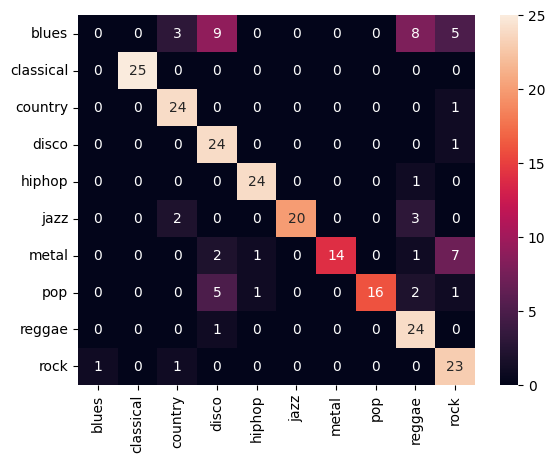

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
testResults = model.predict(testSamples)
import sys
np.set_printoptions(threshold=sys.maxsize)
testL = testLabels.argmax(axis=1)
resultL = testResults.argmax(axis=1)
finalTestLabels = []
finalResultsLabels = []

def most_frequent(List):
    return max(set(list(List)), key = list(List).count)

for index in range(int(len(testL) / 6)):
    finalTestLabels.append(most_frequent(testL[index*6:index*6 + 6]))

for index in range(int(len(resultL) / 6)):
    finalResultsLabels.append(most_frequent(resultL[index*6:index*6 + 6]))

cm = confusion_matrix(np.array(finalTestLabels), np.array(finalResultsLabels))
sns.heatmap(cm, annot=True, xticklabels=genres, yticklabels=genres)
print(classification_report(np.array(finalTestLabels), np.array(finalResultsLabels)))
print("CNN Accuracy: {:.2f}".format(accuracy_score(np.array(finalTestLabels), np.array(finalResultsLabels))))
print("Cohen's Kappa: {:.2f}".format(cohen_kappa_score(np.array(finalTestLabels), np.array(finalResultsLabels))))

## Displaying the Model Training History

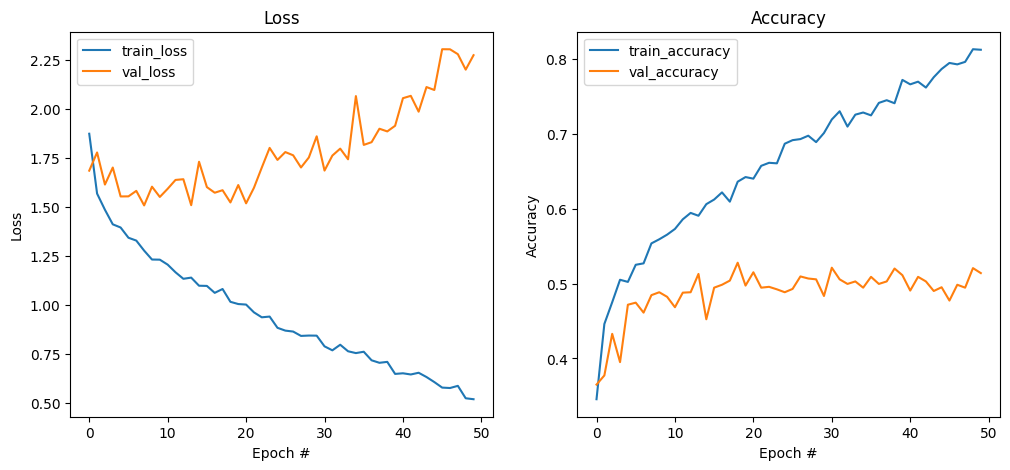

In [ ]:
import matplotlib.pyplot as plt
N = np.arange(0, len(H.history["loss"]))

fig,(loss_plot,acc_plot) = plt.subplots(1,2, figsize=(12, 5))

loss_plot.plot(N, H.history["loss"], label="train_loss")
loss_plot.plot(N, H.history["val_loss"], label="val_loss")
loss_plot.set_title("Loss")
loss_plot.set(xlabel='Epoch #', ylabel='Loss')
loss_plot.legend()

acc_plot.plot(N, H.history["accuracy"], label="train_accuracy")
acc_plot.plot(N, H.history["val_accuracy"], label="val_accuracy")
acc_plot.set_title("Accuracy")
acc_plot.set(xlabel='Epoch #', ylabel='Accuracy')
acc_plot.legend()

# Next Code was ran Locally to Extract the different features

## Different features extraction features

In [ ]:
import os
import librosa
import tqdm
import numpy as np
import matplotlib.pyplot as plt


def to_stft(X, sr, fileName, n_fft=2048, hop_length=512, partNum=0):
    stft = librosa.stft(X, n_fft=n_fft,
                                  hop_length=hop_length)
    plt.figure(figsize=(4.32, 2.88))
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.set_cmap('inferno')
    librosa.display.specshow(stft, sr=sr, hop_length=hop_length)
    plt.tight_layout()

    output_file = fileName + "_" + str(partNum) + '.png'
    plt.savefig(output_file, dpi=100)
    plt.close('all')

def to_chroma_stft(X, sr, fileName, n_fft=2048, hop_length=512, partNum=0):
    chroma = librosa.feature.chroma_stft(y=X, n_fft=n_fft,
                                  hop_length=hop_length)
    plt.figure(figsize=(10, 4))
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.set_cmap('inferno')
    librosa.display.specshow(chroma, sr=sr, hop_length=hop_length)
    plt.tight_layout()

    output_file = fileName + "_" + str(partNum) + '.png'
    plt.savefig(output_file, dpi=100)
    plt.close('all')

def to_chroma_cqt(X, sr, fileName, n_fft=2048, hop_length=512, partNum=0):
    chroma = librosa.feature.chroma_cqt(y=X, sr=sr)
    plt.figure(figsize=(10, 4))
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.set_cmap('inferno')
    librosa.display.specshow(chroma, sr=sr, hop_length=hop_length)
    plt.tight_layout()

    output_file = fileName + "_" + str(partNum) + '.png'
    plt.savefig(output_file, dpi=100)
    plt.close('all')

def to_chroma_cens(X, sr, fileName, n_fft=2048, hop_length=512, partNum=0):
    chroma = librosa.feature.chroma_cens(y=X, sr=sr, n_chroma=12)
    plt.figure(figsize=(10, 4))
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.set_cmap('inferno')
    librosa.display.specshow(chroma, sr=sr, hop_length=hop_length)
    plt.tight_layout()

    output_file = fileName + "_" + str(partNum) + '.png'
    plt.savefig(output_file, dpi=100)
    plt.close('all')

def to_melspectrogram_threshold(X, sr, fileName, n_fft=2048, hop_length=512, partNum=0):
    n_fft = 2048
    hop_length = 512
    n_mels = 128
    fmin = 0
    fmax = None
    threshold_db = -50.0

    spectrogram = librosa.feature.melspectrogram(y=X, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmin=fmin, fmax=fmax)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    spectrogram_masked = np.ma.masked_less_equal(spectrogram_db, threshold_db)

    plt.figure(figsize=(10, 4))
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.set_cmap('inferno')
    librosa.display.specshow(spectrogram_masked, sr=sr, hop_length=hop_length)
    plt.tight_layout()

    output_file = fileName + "_" + partNum + '.png'
    plt.savefig(output_file, dpi=100)
    plt.close('all')

def to_melspectrogram(X, sr, fileName, n_fft=2048, hop_length=512, partNum=0):
    mfcc = librosa.feature.melspectrogram(
        y=X, n_fft=n_fft, hop_length=hop_length)
    plt.figure(figsize=(10, 4))
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.set_cmap('inferno')
    librosa.display.specshow(mfcc, sr=sr, hop_length=hop_length)
    plt.tight_layout()

    output_file = fileName + "_" + str(partNum) + '.png'
    plt.savefig(output_file, dpi=100)
    plt.close('all')


def to_mfcc(X, sr, fileName ,n_fft=2048, hop_length=512, n_mfcc=13, partNum=0):
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(librosa.feature.melspectrogram(
        y=X, n_fft=2048, hop_length=512)), n_mfcc=13)
    plt.figure(figsize=(10, 4))
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.set_cmap('inferno')
    librosa.display.specshow(mfcc, sr=sr, hop_length=hop_length)
    plt.tight_layout()

    output_file = fileName + "_" + str(partNum) + '.png'
    plt.savefig(output_file, dpi=100)
    plt.close('all')

def to_tempograms(X, sr, fileName ,n_fft=1024, hop_length=512, n_mfcc=13, partNum=0):
    # extract onset strength envelope
    onset_env = librosa.onset.onset_strength(y=X, sr=sr)

    # extract tempogram
    tempogram = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr, hop_length=512)
    plt.figure(figsize=(10, 4))
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.set_cmap('inferno')
    librosa.display.specshow(tempogram, sr=sr, hop_length=hop_length)
    plt.tight_layout()

    output_file = fileName + "_" + str(partNum) + '.png'
    plt.savefig(output_file, dpi=100)
    plt.close('all')

## Main extraction function

In [ ]:

def extract_features(mode="stft", n_fft=1024, hop_length=512, n_mfcc=13, duration=0.6):
    print("Read audio files........")
    # Need to change the directory regarding the organization of the dataset
    genre_directory = 'dataset/test'
    genre_label = {}
    label_value = 0
    for folder in os.listdir(genre_directory):
        genre_label[folder] = label_value
        label_value += 1

    X = []
    y = []
    n_rates = 660000
    for folder in os.listdir(genre_directory):
        print('Processing folder {0}'.format(folder))
        for files in tqdm.tqdm(os.listdir(genre_directory+'/'+folder)):
          for i in range(3):
            offsetDuration = i * duration
            data, sr = librosa.load(genre_directory+'/'+folder+'/'+files, offset=offsetDuration, duration=duration)
            data = data[:n_rates]
            X.append(data)
            fileName = folder + '_' + files
            print(fileName)

            if(mode == "chroma_stft"):
              to_chroma_stft(data, sr, fileName, n_fft, hop_length, partNum=i)
            if(mode == "stft"):
              to_stft(data, sr, fileName, n_fft, hop_length, partNum=i)
            if(mode == "tempogram"):
              to_tempograms(data, sr, fileName, n_fft, hop_length, partNum=i)
            if(mode == "mfcc"):
              to_mfcc(data, sr, fileName, n_fft, hop_length, partNum=i)
            if(mode == "melspectrogram"):
              to_melspectrogram(data, sr, fileName, n_fft, hop_length, partNum=i)
            if(mode == "melspectrogram_threshold"):
              to_melspectrogram_threshold(data, sr, fileName, n_fft, hop_length, partNum=i)
            if(mode == "chroma_cqt"):
              to_chroma_cqt(data, sr, fileName, n_fft, hop_length, partNum=i)
            if(mode == "chroma_cens"):
              to_chroma_cens(data, sr, fileName, n_fft, hop_length, partNum=i)


if __name__ == "__main__":
    extract_features(mode="stft", n_fft=2048, hop_length=512, n_mfcc=13, duration=6)